In [1]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from google.colab import drive
import copy

In [2]:
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [3]:
# Load the iris dataset
data = load_iris()
X = data['data']
T = data['target']

def one_hot_encoding(targets):
    # Get unique categories
    categories = np.unique(targets)
    # print('categories:',categories)
    # Get the number of categories
    number_of_categories = categories.size
    # Initialize an array to store the encoded target values
    encoded_T = np.array([list(np.zeros(number_of_categories, dtype=int)) for i in range(targets.size)])

    # Iterate through each target value and encode it
    for (i, t) in enumerate(targets):
        # Get the index of the category in the unique categories array
        category_index = list(categories).index(t)
        # Set the corresponding element in the encoded target array to 1
        encoded_T[i][category_index] = 1
    return encoded_T

In [4]:
def weighted_sum(x, w, b):
    """
    Compute the weighted sum of inputs.

    Parameters:
    x (numpy.ndarray): Input data.
    w (numpy.ndarray): Weights matrix.
    b (numpy.ndarray): Bias vector.

    Returns:
    numpy.ndarray or None: Weighted sum of inputs, or None if an error occurs.
    """
    try:
        # print(w.shape,x.shape)
        w = w.transpose()
        # print(w.shape,x.shape)
        z = np.dot(w, x) + b

        return z
    except Exception as e:
        # Handle exceptions, if any, and print an error message.
        print("An error occurred:", e)
        return


In [5]:
def tanh(z):
    """
    Compute the hyperbolic tangent function.

    Parameters:
    z (numpy.ndarray): Input array.

    Returns:
    numpy.ndarray: Output of the hyperbolic tangent function.
    """
    return (np.exp(z) - np.exp(-z)) / (np.exp(z) + np.exp(-z))

def sigmoid(z):
    """
    Compute the sigmoid function.

    Parameters:
    z (numpy.ndarray): Input array.

    Returns:
    numpy.ndarray: Output of the sigmoid function.
    """

    return 1 / (1 + np.exp(-z))

def relu(z):
    """
    Compute the ReLU (Rectified Linear Unit) function.

    Parameters:
    z (numpy.ndarray): Input array.

    Returns:
    numpy.ndarray: Output of the ReLU function.
    """
    z[z <= 0] = 0
    return z

def softmax(z):
    exp_z=np.exp(z)
    return  exp_z/ np.sum(exp_z)

In [6]:
def sum_of_square(y,t):
   return np.sum((y-t)**2)/2

In [7]:
def feedforward_activation(input_x, weights, biases, activation='sigmoid'):
    """
    Perform a feedforward operation with an optional activation function.

    Parameters:
    input_x (numpy.ndarray): Input data.
    weights (numpy.ndarray): Weights for the feedforward operation.
    biases (numpy.ndarray): Biases for the feedforward operation.
    activation (str): Activation function to use ('sigmoid', 'tanh', or 'relu'). Default is 'sigmoid'.

    Returns:
    numpy.ndarray: Output of the feedforward operation with optional activation.
    """
    z = weighted_sum(input_x, weights, biases)

    if activation == 'tanh':
        nodes = tanh(z)
    elif activation == 'sigmoid':
        nodes = sigmoid(z)
    elif activation == 'relu':
        nodes = relu(z)
    elif activation=='softmax':
          nodes =softmax(z)
    else:
        print('Selected activation not supported, Please select sigmoid, tanh, or relu')
    return nodes,z


In [8]:
def delta_n(a_n,t_n):
     return (a_n-t_n)*a_n*(1-a_n)

In [9]:
def delta_m(a_m,w,s_n):

    try:
        return np.dot(w,s_n)
    except Exception as e:
        # Handle exceptions, if any, and print an error message.
        print("An error occurred:", e)
        return

In [10]:
def plot_loss(cost):
    plt.plot(range(len(cost)),cost)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.show()

In [11]:
def feedforward(input_x, weights, biases,number_of_layers_excluding_input=1, hidden_layer_activation='sigmoid',
                output_activation='sigmoid'):
    """
    Perform a feedforward operation through the neural network.

    Parameters:
    input_x (numpy.ndarray): Input data.
    weights (list of numpy.ndarray): List of weight matrices for each layer.
    biases (list of numpy.ndarray): List of bias vectors for each layer.
    hidden_layer_activation (str): Activation function for hidden layers. Default is 'sigmoid'.
    output_activation (str): Activation function for the output layer. Default is 'sigmoid'.
    number_of_layers_excluding_input (int): Number of layers excluding input in the network. Default is 1.
    """

    # List to store the outputs of each layer
    a0,z0=feedforward_activation(input_x[0], weights[0], biases[0], hidden_layer_activation)
    layer_outputs = [a0]
    weight_sums=[z0]

    # Loop through each hidden layer
    if number_of_layers_excluding_input > 1:
        for num_layer in range(1, number_of_layers_excluding_input):

            # If not the last hidden layer
            if num_layer != number_of_layers_excluding_input-1:

                # Perform feedforward with hidden layer activation
                a,z=feedforward_activation(layer_outputs[-1], weights[num_layer], biases[num_layer], hidden_layer_activation)
                layer_outputs.append(a)
                weight_sums.append(z)

            else:
                # Perform feedforward with output layer activation for the last layer

                a,z=feedforward_activation(layer_outputs[-1], weights[num_layer], biases[num_layer], output_activation)
                layer_outputs.append(a)
                weight_sums.append(z)

    return layer_outputs,weight_sums

In [30]:
def neural_training(input_x, T, number_of_nodes_per_hidden_layer=[], learning_rate=0.01, hidden_layer_activation='sigmoid', output_activation='sigmoid',
                    nodes_inc=2, min_epoch=2, max_epoch=3000, acceptable_accuracy=0.75):
    # Determine the number of input features
    number_of_features = input_x[0].size
    num_output_nodes=len(T[0])
    plot_ann_architecture(number_of_nodes_per_hidden_layer, number_of_features, num_output_nodes)
    # If no hidden layer structure is provided, create a default structure
    if len(number_of_nodes_per_hidden_layer) == 0:
        number_of_layers_excluding_input = int(number_of_features * 2 / 3) + 1
        number_of_nodes_per_hidden_layer = [number_of_features + nodes_inc for _ in range(number_of_layers_excluding_input - 1)]
    else:
        number_of_layers_excluding_input = len(number_of_nodes_per_hidden_layer) + 1

    # Add the number of output nodes to the hidden layer structure
    number_of_nodes_per_hidden_layer.append(num_output_nodes)

    # Initialize weights and biases with random values
    w = [np.random.uniform(low=-1, high=1, size=(number_of_features, number_of_nodes_per_hidden_layer[0]))]
    b = [np.random.uniform(low=-1, high=1, size=(num)) for num in number_of_nodes_per_hidden_layer]

    for i in range(0, number_of_layers_excluding_input - 1):
        w.append(np.random.uniform(low=-1, high=1, size=(number_of_nodes_per_hidden_layer[i], number_of_nodes_per_hidden_layer[i + 1])))

    # Combine input features and targets into a dataset
    D = np.array(list(zip(input_x, T)), dtype=object)

    # Initialize the cost list
    cost = []

    # Initialize the epoch counter
    epoch = 1

    # Training loop
    while True:
        # Shuffle the dataset
        # np.random.shuffle(D)

        # Lists to store predicted and actual targets
        pred_target = []


        prev_w = copy.deepcopy(w)
        for (x, t) in D:
            # Perform feedforward pass
            output_activations, z = feedforward([x], w, b, number_of_layers_excluding_input, hidden_layer_activation=hidden_layer_activation, output_activation=output_activation)
            pred_target.append([output_activations[-1], t])
            errors = []

            # Calculate output layer error
            s_n = delta_n(output_activations[-1], t)
            errors.append(s_n)
            print(' w[::-1]=', w[::-1])
            # Backpropagate the error through the network
            for (a_m, w_mn) in zip(output_activations[:-1][::-1], w[::-1]):

                s_n = errors[-1]
                s_m = delta_m(a_m, w_mn, s_n)
                errors.append(s_m)

            # Update weights and biases using gradient descent
            for (i, (a_m, s_n)) in enumerate(zip(output_activations, errors[::-1])):
                w[i] -= learning_rate * s_n * a_m
                b[i] -= learning_rate * s_n

                print()

        # Calculate and store the cost function
        cost.append(sum_of_square(np.array(pred_target)[:, 0], np.array(pred_target)[:, 1]))

        # Calculate accuracy
        accuracy = 1 - cost[-1] / T.size

        # Check if weights have not changed
        no_update = all(np.array_equal(a, b) for a, b in zip(w,prev_w))

        # Check termination conditions
        if epoch >= max_epoch or (accuracy >= acceptable_accuracy and epoch >= min_epoch) or (no_update):
            print(f'epoch >= max_epoch={epoch >= max_epoch} or (accuracy >= acceptable_accuracy and epoch >= min_epoch)={accuracy >= acceptable_accuracy and epoch >= min_epoch} or no_update={no_update}')
            print('Model accuarcy=',accuracy)
            plot_loss(cost)
            break
         # Increment epoch counter
        epoch += 1

    return accuracy, [w, b, np.array(pred_target)[:, 0]]


In [31]:
def plot_ann_architecture(number_of_nodes_per_hidden_layer, input_nodes, output_nodes):
    layers = [input_nodes] + number_of_nodes_per_hidden_layer + [output_nodes]
    num_layers = len(layers)

    plt.figure(figsize=(10, 6))
    for i in range(1, num_layers):
        plt.scatter([i+1 ] * layers[i], range(1, layers[i] + 1), color='blue')  # Adjusted x-coordinate
        for j in range(layers[i-1]):
            for k in range(layers[i]):
                plt.plot([i, i+1], [j+1, k+1], color='gray')  # Changed the x-coordinates to remove the offset

    plt.xlabel('Layer')
    plt.ylabel('Node')
    plt.title('Artificial Neural Network Architecture')
    plt.grid(True)
    plt.show()

Code up the backprogation algorithm for a neural network with an input layer, a single
 hidden layer and an output layer, with sigmoid activation function at the hidden layer and
 output layer. The loss function is the sum-of-squares loss.

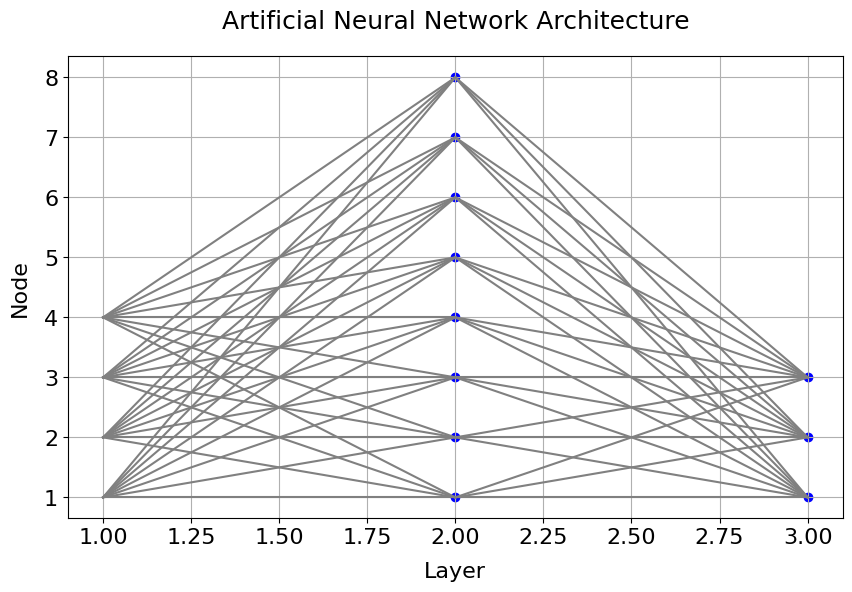

Streaming output truncated to the last 5000 lines.
 w[::-1]= [array([[-1.05709654,  0.78249526, -0.30426655],
       [ 0.84529986,  0.85309809,  0.54538406],
       [-0.49911199, -0.30394641,  0.5416385 ],
       [-0.45416576, -0.73515637, -0.04703232],
       [ 0.78429977,  0.31791773, -0.02051251],
       [-0.89365679,  0.15587259,  0.81947285],
       [-0.80784174, -0.03748256,  0.5941113 ],
       [ 0.39352746,  0.31988962,  0.24433332]]), array([[-0.83061762, -0.72195375,  0.75186871,  0.38137081, -0.9817127 ,
        -0.80938148,  0.30066552, -0.99005008],
       [-0.67728144,  0.0522564 ,  0.33855073,  0.47243521, -0.55156819,
         0.41203388, -0.55183984, -0.34937385],
       [ 0.49408526,  0.25405462,  0.65320716,  0.48373848,  0.1365104 ,
        -0.82497503, -0.29090641, -0.46976851],
       [-0.51091826,  0.90080994, -0.25904421,  0.9526058 ,  0.26217044,
         0.57729804, -0.02106383,  0.15363453]])]


 w[::-1]= [array([[-1.05650998,  0.78206644, -0.30496412],
     

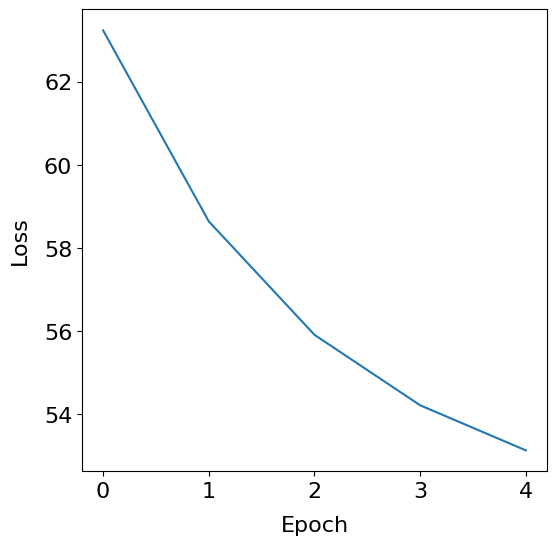

In [32]:
input_X=data['data']
targets=one_hot_encoding(T)

a_rate,[w,b,res]=neural_training(input_X,targets,learning_rate=0.01,number_of_nodes_per_hidden_layer=[8],hidden_layer_activation='sigmoid',output_activation='sigmoid',
                                 acceptable_accuracy=0.88,min_epoch=2)

In [15]:
# Specifying the file path where the dataset is stored on Google Drive
file_path = '/content/gdrive/MyDrive/MSc e-Science/ACML/datasets/xor_data_train.csv'
file_path_one = '/content/gdrive/MyDrive/MSc e-Science/ACML/datasets/xor_data_test.csv'
# Reading the dataset from the specified csv file into a Pandas DataFrame
data1 = pd.read_csv(file_path)
data2 = pd.read_csv(file_path_one)
# Concatenate the two DataFrames
xor_data = pd.concat([data1, data2], ignore_index=True)

len(xor_data[xor_data['class']==1])

192

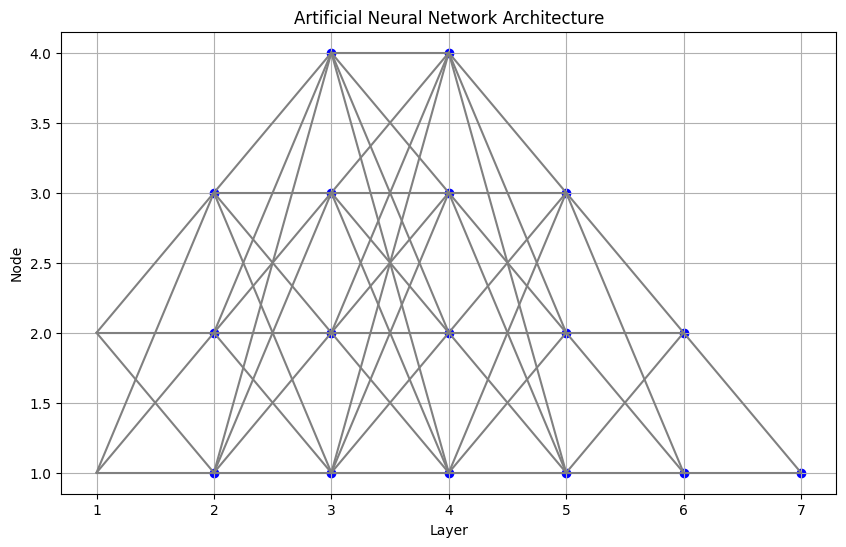

epoch >= max_epoch=False or (accuracy >= acceptable_accuracy and epoch >= min_epoch)=True or no_update=False
Model accuarcy= 0.874635616126825


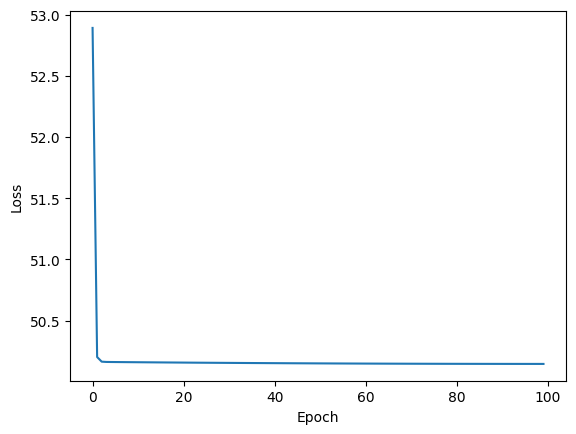

In [16]:
input_X=xor_data[['x1','x2']].to_numpy()
targets=xor_data['class'].to_numpy().reshape(-1,1)

model_accuarcy,[weights,biases,output]=neural_training(input_X,targets,number_of_nodes_per_hidden_layer=[3,4,4,3,2],learning_rate=0.05,min_epoch=100,max_epoch=10000,acceptable_accuracy=0.87)

In [17]:
import random
import math
np.random.seed(42)

import matplotlib.pyplot as plt
FONTSIZE = 16
params = {
         'figure.figsize' : (6,6),
         'axes.labelsize' : FONTSIZE,
         'axes.titlesize' : FONTSIZE+2,
         'legend.fontsize': FONTSIZE,
         'xtick.labelsize': FONTSIZE,
         'ytick.labelsize': FONTSIZE,
         'xtick.color'    : 'black',
         'ytick.color'    : 'black',
         'axes.facecolor' : 'white',
         'axes.edgecolor' : 'black',
         'axes.titlepad'  :  20,
         'axes.labelpad'  :  10}
plt.rcParams.update(params)

XNAME = 'x1'; XLABEL = r'$x_1$'
YNAME = 'x2'; YLABEL = r'$x_2$'
RANGE = (-6, 6); STEP = 0.65

def predict(output_node, boundary_value):
  # output_node.reshape(-1, 1, 1) # a list (m, 1, 1)
  predictions = np.array(output_node > boundary_value, dtype=int)
  return predictions

def get_decision_surface(output, boundary=0.5, range=RANGE, step=STEP):

  # Create a grid of points spanning the parameter space:
  x1v, x2v = np.meshgrid(np.arange(range[0], range[1]+step, step),
                         np.arange(range[0], range[1]+step, step))

  # Stack it so that it is shaped like X_train: (m,2)
  X_grid = np.c_[x1v.ravel(), x2v.ravel()].reshape(-1,2)

  # Feedforward on all grid points and get binary predictions:
  # output = feedforward(X_grid, weights, biases)[-1] # getting only output node
  Ypred_grid = predict(output, boundary)

  return (x1v, x2v, Ypred_grid.reshape(x1v.shape))


def plot_scatter(sig, bkg, ds=None, xname=XNAME, xlabel=XLABEL, yname=YNAME, ylabel=YLABEL, range=RANGE, step=STEP, title="Scatter plot"):

  fig, ax = plt.subplots()

  # Decision surface
  if ds:
    (xx, yy, Z) = ds # unpack contour data
    cs = plt.contourf(xx, yy, Z, levels=[0,0.5,1], colors=['orange','dodgerblue'], alpha=0.3)

  # Scatter signal and background:
  ax.scatter(sig[xname], sig[yname], marker='o', s=10, c='dodgerblue', alpha=1, label='Positive class')
  ax.scatter(bkg[xname], bkg[yname], marker='o', s=10, c='orange',     alpha=1, label='Negative class')

  # Axes, legend and plot:
  ax.set_xlim(range); ax.set_xlabel(xlabel)
  ax.set_ylim(range); ax.set_ylabel(ylabel)

  ax.legend(bbox_to_anchor=(1.04, 0.5), loc="center left", frameon=False)
  ax.set_title(title)
  plt.show()

In [18]:
bkg=xor_data[xor_data['class']==0]
sig=xor_data[xor_data['class']==1]
ds=get_decision_surface(output, boundary=0.5, range=RANGE, step=STEP)
# plot_scatter(sig, bkg, ds, xname=XNAME, xlabel=XLABEL, yname=YNAME, ylabel=YLABEL, range=RANGE, step=STEP, title="Scatter plot")

sum(predict(output, boundary_value=0.5)==targets)

array([202])